In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
torch.__version__

'1.6.0'

In [3]:
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_amp_pha_10nm_full.npy?raw=true 
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_diff.npz?raw=true


In [4]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [5]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [6]:
EPS32 = (1.0 + np.finfo(np.float32).eps)
def histogram2d_engine(raw, npt, 
                       radial_range=None,
                       azimuth_range=None
                       ):
    """Implementation of 2D rebinning engine using pure numpy histograms
    
    :param npt: number of points to integrate over in (azimuthal, radial) dimension
    :param raw: 2D array with the raw signal
    """
    
    shape = raw.shape
    y = np.linspace(-shape[0] / 2, shape[0] / 2, shape[0])
    x = np.linspace(-shape[1] / 2, shape[1] / 2, shape[1])
    yy, xx = np.meshgrid(y, x, indexing='ij')
    
    radial = (yy**2 + xx**2)**0.5
    azimuth = np.arctan2(yy, xx)
    
    raw = np.ascontiguousarray(raw.ravel())
    radial = radial.ravel()
    azimuth = azimuth.ravel()
    
    if radial_range is None:
        radial_range = (radial.min(), radial.max() * EPS32)
    if azimuth_range is None:
        azimuth_range = (azimuth.min(), azimuth.max() * EPS32)
    
    histo_count, position_azim, position_rad = np.histogram2d(azimuth, radial, npt, weights=raw, range=[azimuth_range, radial_range])

    bins_azim = (position_azim[1:] + position_azim[:-1]) / 2.0
    bins_rad = (position_rad[1:] + position_rad[:-1]) / 2.0
    return histo_count, bins_azim, bins_rad

In [7]:
torch.cuda.device_count()

2

In [8]:
EPOCHS = 20
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 64
LR = 1e-3 
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 2 Batch size: 128 Learning rate: 0.001


In [9]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

**Note that the "path" can be different for different directory structures. For example, the original code in train.ipynb contains a different path.**  

In [10]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [11]:
real_space = np.load('../data/20191008_39_amp_pha_10nm_full.npy')#np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')

In [12]:
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [13]:
try:
    
    data_diffr_red = np.load('../data/20191008_39_diff_azimuth_full.npz')['arr_0']
except:
    data_diffr = np.load('../data/20191008_39_diff.npz')['arr_0']#np.load(path+'/../data/20191008_39_diff.npz')['arr_0']

    print(data_diffr.shape)
    #plt.matshow(np.log10(data_diffr[0,0]))

    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), dtype=float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            histo_count_2d, bins_azim, bins_rad = histogram2d_engine(data_diffr[i,j]**2, (64, 64))
            data_diffr_red[i,j] = histo_count_2d#resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            #data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3, 0, data_diffr_red[i,j])
    np.savez_compressed('../data/20191008_39_diff_azimuth_full.npz', data_diffr_red)

  0%|          | 0/161 [00:00<?, ?it/s]

(161, 161, 256, 256)


100%|██████████| 161/161 [02:28<00:00,  1.09it/s]


In [14]:
#data_diffr_red = np.log(data_diffr_red + 1)
data_diffr_red = data_diffr_red**0.5

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


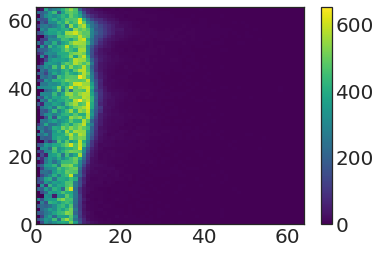

In [15]:
plt.pcolormesh(data_diffr_red[0,0])
plt.colorbar()
plt.show()

In [16]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [17]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [18]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [19]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [20]:
nconv = 32


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            amp = self.decoder1(x1)
            ph = self.decoder2(x1)

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

In [21]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp_train, ph_train = model(ft_images)
    print(amp_train.shape, ph_train.shape)
    print(amp_train.dtype, ph_train.dtype)
    break

batch size: torch.Size([128, 1, 64, 64])


/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64])
torch.float32 torch.float32


In [22]:
summary(model,(1,H,W),device="cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 8, 8]           --
|    └─Conv2d: 2-1                       [-1, 32, 64, 64]          320
|    └─ReLU: 2-2                         [-1, 32, 64, 64]          --
|    └─Conv2d: 2-3                       [-1, 32, 64, 64]          9,248
|    └─ReLU: 2-4                         [-1, 32, 64, 64]          --
|    └─MaxPool2d: 2-5                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-6                       [-1, 64, 32, 32]          18,496
|    └─ReLU: 2-7                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-8                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-9                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-10                   [-1, 64, 16, 16]          --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-12                        [-1, 128, 16, 16]         --

In [23]:
#Optimizer details
iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

criterion = nn.L1Loss()#
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR / 10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, min_lr=LR / 10)

LR step size is: 720.0 which is every 6 epochs


In [24]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

**For the "mixed precision" part we just modify the original code slightly to include the 'scaler' in the following code blocks**

In [25]:
scaler = torch.cuda.amp.GradScaler()

In [26]:
def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_a + loss_p #Use equiweighted amps and phase
        
       
        #print(loss)
        #Zero current grads and do backprop
        optimizer.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()
        
        

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        scaler.update()
        #print(loss)
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        pred_amps, pred_phs = model(ft_images) #Forward pass
    
    
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
           
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [27]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

In [44]:

#train(trainloader,metrics)

for epoch in range (100):#EPOCHS):

  
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

0it [00:00, ?it/s]/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
120it [00:16,  7.15it/s]


Epoch: 0 | FT  | Train Loss: 0.14993 | Val Loss: 0.33043
Epoch: 0 | Amp | Train Loss: 0.0058 | Val Loss: 0.0073
Epoch: 0 | Ph  | Train Loss: 0.144 | Val Loss: 0.323
Epoch: 0 | Ending LR: 0.000103 


120it [00:16,  7.21it/s]


Epoch: 1 | FT  | Train Loss: 0.14909 | Val Loss: 0.33167
Epoch: 1 | Amp | Train Loss: 0.0058 | Val Loss: 0.0073
Epoch: 1 | Ph  | Train Loss: 0.143 | Val Loss: 0.324
Epoch: 1 | Ending LR: 0.000104 


120it [00:16,  7.13it/s]


Epoch: 2 | FT  | Train Loss: 0.14904 | Val Loss: 0.33219
Epoch: 2 | Amp | Train Loss: 0.0058 | Val Loss: 0.0073
Epoch: 2 | Ph  | Train Loss: 0.143 | Val Loss: 0.325
Epoch: 2 | Ending LR: 0.000103 


120it [00:16,  7.15it/s]


Epoch: 3 | FT  | Train Loss: 0.14823 | Val Loss: 0.32995
Epoch: 3 | Amp | Train Loss: 0.0058 | Val Loss: 0.0073
Epoch: 3 | Ph  | Train Loss: 0.142 | Val Loss: 0.323
Epoch: 3 | Ending LR: 0.000102 


120it [00:16,  7.12it/s]


Epoch: 4 | FT  | Train Loss: 0.14814 | Val Loss: 0.33285
Epoch: 4 | Amp | Train Loss: 0.0058 | Val Loss: 0.0073
Epoch: 4 | Ph  | Train Loss: 0.142 | Val Loss: 0.326
Epoch: 4 | Ending LR: 0.000102 


120it [00:17,  7.03it/s]


Epoch: 5 | FT  | Train Loss: 0.14776 | Val Loss: 0.32961
Epoch: 5 | Amp | Train Loss: 0.0057 | Val Loss: 0.0073
Epoch: 5 | Ph  | Train Loss: 0.142 | Val Loss: 0.322
Epoch: 5 | Ending LR: 0.000101 


120it [00:16,  7.10it/s]


Epoch: 6 | FT  | Train Loss: 0.14696 | Val Loss: 0.33039
Epoch: 6 | Amp | Train Loss: 0.0057 | Val Loss: 0.0074
Epoch: 6 | Ph  | Train Loss: 0.141 | Val Loss: 0.323
Epoch: 6 | Ending LR: 0.000101 


120it [00:16,  7.11it/s]


Epoch: 7 | FT  | Train Loss: 0.14638 | Val Loss: 0.33126
Epoch: 7 | Amp | Train Loss: 0.0057 | Val Loss: 0.0074
Epoch: 7 | Ph  | Train Loss: 0.141 | Val Loss: 0.324
Epoch: 7 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Saving improved model after Val Loss improved from 0.32935 to 0.32878
Epoch: 8 | FT  | Train Loss: 0.14603 | Val Loss: 0.32878
Epoch: 8 | Amp | Train Loss: 0.0057 | Val Loss: 0.0073
Epoch: 8 | Ph  | Train Loss: 0.140 | Val Loss: 0.322
Epoch: 8 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 9 | FT  | Train Loss: 0.14599 | Val Loss: 0.33058
Epoch: 9 | Amp | Train Loss: 0.0057 | Val Loss: 0.0073
Epoch: 9 | Ph  | Train Loss: 0.140 | Val Loss: 0.323
Epoch: 9 | Ending LR: 0.000101 


120it [00:16,  7.11it/s]


Epoch: 10 | FT  | Train Loss: 0.14565 | Val Loss: 0.32989
Epoch: 10 | Amp | Train Loss: 0.0057 | Val Loss: 0.0073
Epoch: 10 | Ph  | Train Loss: 0.140 | Val Loss: 0.323
Epoch: 10 | Ending LR: 0.000101 


120it [00:16,  7.07it/s]


Epoch: 11 | FT  | Train Loss: 0.14519 | Val Loss: 0.33174
Epoch: 11 | Amp | Train Loss: 0.0057 | Val Loss: 0.0073
Epoch: 11 | Ph  | Train Loss: 0.140 | Val Loss: 0.324
Epoch: 11 | Ending LR: 0.000101 


120it [00:16,  7.11it/s]


Epoch: 12 | FT  | Train Loss: 0.14468 | Val Loss: 0.33093
Epoch: 12 | Amp | Train Loss: 0.0057 | Val Loss: 0.0073
Epoch: 12 | Ph  | Train Loss: 0.139 | Val Loss: 0.324
Epoch: 12 | Ending LR: 0.000101 


120it [00:17,  6.97it/s]


Epoch: 13 | FT  | Train Loss: 0.14427 | Val Loss: 0.33010
Epoch: 13 | Amp | Train Loss: 0.0057 | Val Loss: 0.0073
Epoch: 13 | Ph  | Train Loss: 0.139 | Val Loss: 0.323
Epoch: 13 | Ending LR: 0.000102 


120it [00:16,  7.11it/s]


Epoch: 14 | FT  | Train Loss: 0.14419 | Val Loss: 0.33060
Epoch: 14 | Amp | Train Loss: 0.0057 | Val Loss: 0.0073
Epoch: 14 | Ph  | Train Loss: 0.139 | Val Loss: 0.323
Epoch: 14 | Ending LR: 0.000101 


120it [00:16,  7.10it/s]


Epoch: 15 | FT  | Train Loss: 0.14415 | Val Loss: 0.33144
Epoch: 15 | Amp | Train Loss: 0.0057 | Val Loss: 0.0073
Epoch: 15 | Ph  | Train Loss: 0.138 | Val Loss: 0.324
Epoch: 15 | Ending LR: 0.000101 


120it [00:16,  7.11it/s]


Epoch: 16 | FT  | Train Loss: 0.14378 | Val Loss: 0.32888
Epoch: 16 | Amp | Train Loss: 0.0057 | Val Loss: 0.0073
Epoch: 16 | Ph  | Train Loss: 0.138 | Val Loss: 0.322
Epoch: 16 | Ending LR: 0.000101 


120it [00:16,  7.10it/s]


Epoch: 17 | FT  | Train Loss: 0.14318 | Val Loss: 0.32991
Epoch: 17 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 17 | Ph  | Train Loss: 0.138 | Val Loss: 0.323
Epoch: 17 | Ending LR: 0.000101 


120it [00:16,  7.11it/s]


Epoch: 18 | FT  | Train Loss: 0.14263 | Val Loss: 0.32932
Epoch: 18 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 18 | Ph  | Train Loss: 0.137 | Val Loss: 0.322
Epoch: 18 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 19 | FT  | Train Loss: 0.14265 | Val Loss: 0.33058
Epoch: 19 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 19 | Ph  | Train Loss: 0.137 | Val Loss: 0.323
Epoch: 19 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 20 | FT  | Train Loss: 0.14234 | Val Loss: 0.33262
Epoch: 20 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 20 | Ph  | Train Loss: 0.137 | Val Loss: 0.325
Epoch: 20 | Ending LR: 0.000100 


120it [00:17,  6.99it/s]


Epoch: 21 | FT  | Train Loss: 0.14221 | Val Loss: 0.32953
Epoch: 21 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 21 | Ph  | Train Loss: 0.137 | Val Loss: 0.322
Epoch: 21 | Ending LR: 0.000100 


120it [00:16,  7.08it/s]


Epoch: 22 | FT  | Train Loss: 0.14169 | Val Loss: 0.32929
Epoch: 22 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 22 | Ph  | Train Loss: 0.136 | Val Loss: 0.322
Epoch: 22 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 23 | FT  | Train Loss: 0.14135 | Val Loss: 0.32902
Epoch: 23 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 23 | Ph  | Train Loss: 0.136 | Val Loss: 0.322
Epoch: 23 | Ending LR: 0.000101 


120it [00:16,  7.11it/s]


Epoch: 24 | FT  | Train Loss: 0.14120 | Val Loss: 0.32928
Epoch: 24 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 24 | Ph  | Train Loss: 0.136 | Val Loss: 0.322
Epoch: 24 | Ending LR: 0.000101 


120it [00:16,  7.11it/s]


Epoch: 25 | FT  | Train Loss: 0.14074 | Val Loss: 0.33139
Epoch: 25 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 25 | Ph  | Train Loss: 0.135 | Val Loss: 0.324
Epoch: 25 | Ending LR: 0.000101 


120it [00:16,  7.09it/s]


Saving improved model after Val Loss improved from 0.32878 to 0.32659
Epoch: 26 | FT  | Train Loss: 0.14042 | Val Loss: 0.32659
Epoch: 26 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 26 | Ph  | Train Loss: 0.135 | Val Loss: 0.319
Epoch: 26 | Ending LR: 0.000101 


120it [00:17,  6.99it/s]


Epoch: 27 | FT  | Train Loss: 0.14056 | Val Loss: 0.33022
Epoch: 27 | Amp | Train Loss: 0.0056 | Val Loss: 0.0073
Epoch: 27 | Ph  | Train Loss: 0.135 | Val Loss: 0.323
Epoch: 27 | Ending LR: 0.000101 


120it [00:17,  6.75it/s]


Epoch: 28 | FT  | Train Loss: 0.14008 | Val Loss: 0.33215
Epoch: 28 | Amp | Train Loss: 0.0055 | Val Loss: 0.0073
Epoch: 28 | Ph  | Train Loss: 0.135 | Val Loss: 0.325
Epoch: 28 | Ending LR: 0.000100 


120it [00:19,  6.19it/s]


Epoch: 29 | FT  | Train Loss: 0.14007 | Val Loss: 0.32659
Epoch: 29 | Amp | Train Loss: 0.0055 | Val Loss: 0.0073
Epoch: 29 | Ph  | Train Loss: 0.135 | Val Loss: 0.319
Epoch: 29 | Ending LR: 0.000100 


120it [00:19,  6.07it/s]


Epoch: 30 | FT  | Train Loss: 0.13937 | Val Loss: 0.33015
Epoch: 30 | Amp | Train Loss: 0.0055 | Val Loss: 0.0073
Epoch: 30 | Ph  | Train Loss: 0.134 | Val Loss: 0.323
Epoch: 30 | Ending LR: 0.000100 


120it [00:19,  6.06it/s]


Epoch: 31 | FT  | Train Loss: 0.13933 | Val Loss: 0.32891
Epoch: 31 | Amp | Train Loss: 0.0055 | Val Loss: 0.0073
Epoch: 31 | Ph  | Train Loss: 0.134 | Val Loss: 0.322
Epoch: 31 | Ending LR: 0.000100 


120it [00:17,  6.81it/s]


Epoch: 32 | FT  | Train Loss: 0.13871 | Val Loss: 0.32892
Epoch: 32 | Amp | Train Loss: 0.0055 | Val Loss: 0.0073
Epoch: 32 | Ph  | Train Loss: 0.133 | Val Loss: 0.322
Epoch: 32 | Ending LR: 0.000100 


120it [00:16,  7.08it/s]


Epoch: 33 | FT  | Train Loss: 0.13810 | Val Loss: 0.32790
Epoch: 33 | Amp | Train Loss: 0.0055 | Val Loss: 0.0072
Epoch: 33 | Ph  | Train Loss: 0.133 | Val Loss: 0.321
Epoch: 33 | Ending LR: 0.000100 


120it [00:16,  7.08it/s]


Epoch: 34 | FT  | Train Loss: 0.13767 | Val Loss: 0.32886
Epoch: 34 | Amp | Train Loss: 0.0055 | Val Loss: 0.0073
Epoch: 34 | Ph  | Train Loss: 0.132 | Val Loss: 0.322
Epoch: 34 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 35 | FT  | Train Loss: 0.13746 | Val Loss: 0.33129
Epoch: 35 | Amp | Train Loss: 0.0055 | Val Loss: 0.0073
Epoch: 35 | Ph  | Train Loss: 0.132 | Val Loss: 0.324
Epoch: 35 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 36 | FT  | Train Loss: 0.13800 | Val Loss: 0.32859
Epoch: 36 | Amp | Train Loss: 0.0055 | Val Loss: 0.0072
Epoch: 36 | Ph  | Train Loss: 0.133 | Val Loss: 0.321
Epoch: 36 | Ending LR: 0.000100 


120it [00:17,  7.05it/s]


Epoch: 37 | FT  | Train Loss: 0.13718 | Val Loss: 0.33067
Epoch: 37 | Amp | Train Loss: 0.0055 | Val Loss: 0.0073
Epoch: 37 | Ph  | Train Loss: 0.132 | Val Loss: 0.323
Epoch: 37 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 38 | FT  | Train Loss: 0.13727 | Val Loss: 0.32977
Epoch: 38 | Amp | Train Loss: 0.0055 | Val Loss: 0.0073
Epoch: 38 | Ph  | Train Loss: 0.132 | Val Loss: 0.322
Epoch: 38 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 39 | FT  | Train Loss: 0.13683 | Val Loss: 0.32673
Epoch: 39 | Amp | Train Loss: 0.0055 | Val Loss: 0.0072
Epoch: 39 | Ph  | Train Loss: 0.131 | Val Loss: 0.319
Epoch: 39 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 40 | FT  | Train Loss: 0.13670 | Val Loss: 0.32841
Epoch: 40 | Amp | Train Loss: 0.0054 | Val Loss: 0.0073
Epoch: 40 | Ph  | Train Loss: 0.131 | Val Loss: 0.321
Epoch: 40 | Ending LR: 0.000100 


120it [00:17,  7.04it/s]


Epoch: 41 | FT  | Train Loss: 0.13638 | Val Loss: 0.32836
Epoch: 41 | Amp | Train Loss: 0.0054 | Val Loss: 0.0073
Epoch: 41 | Ph  | Train Loss: 0.131 | Val Loss: 0.321
Epoch: 41 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 42 | FT  | Train Loss: 0.13571 | Val Loss: 0.33017
Epoch: 42 | Amp | Train Loss: 0.0054 | Val Loss: 0.0073
Epoch: 42 | Ph  | Train Loss: 0.130 | Val Loss: 0.323
Epoch: 42 | Ending LR: 0.000100 


120it [00:16,  7.09it/s]


Epoch: 43 | FT  | Train Loss: 0.13584 | Val Loss: 0.32905
Epoch: 43 | Amp | Train Loss: 0.0054 | Val Loss: 0.0073
Epoch: 43 | Ph  | Train Loss: 0.130 | Val Loss: 0.322
Epoch: 43 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 44 | FT  | Train Loss: 0.13550 | Val Loss: 0.32956
Epoch: 44 | Amp | Train Loss: 0.0054 | Val Loss: 0.0073
Epoch: 44 | Ph  | Train Loss: 0.130 | Val Loss: 0.322
Epoch: 44 | Ending LR: 0.000100 


120it [00:17,  7.03it/s]


Epoch: 45 | FT  | Train Loss: 0.13560 | Val Loss: 0.33171
Epoch: 45 | Amp | Train Loss: 0.0054 | Val Loss: 0.0073
Epoch: 45 | Ph  | Train Loss: 0.130 | Val Loss: 0.324
Epoch: 45 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 46 | FT  | Train Loss: 0.13523 | Val Loss: 0.32877
Epoch: 46 | Amp | Train Loss: 0.0054 | Val Loss: 0.0073
Epoch: 46 | Ph  | Train Loss: 0.130 | Val Loss: 0.321
Epoch: 46 | Ending LR: 0.000100 


120it [00:16,  7.07it/s]


Epoch: 47 | FT  | Train Loss: 0.13528 | Val Loss: 0.33111
Epoch: 47 | Amp | Train Loss: 0.0054 | Val Loss: 0.0073
Epoch: 47 | Ph  | Train Loss: 0.130 | Val Loss: 0.324
Epoch: 47 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 48 | FT  | Train Loss: 0.13496 | Val Loss: 0.32865
Epoch: 48 | Amp | Train Loss: 0.0054 | Val Loss: 0.0073
Epoch: 48 | Ph  | Train Loss: 0.130 | Val Loss: 0.321
Epoch: 48 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 49 | FT  | Train Loss: 0.13458 | Val Loss: 0.33001
Epoch: 49 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 49 | Ph  | Train Loss: 0.129 | Val Loss: 0.323
Epoch: 49 | Ending LR: 0.000100 


120it [00:16,  7.09it/s]


Epoch: 50 | FT  | Train Loss: 0.13460 | Val Loss: 0.33010
Epoch: 50 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 50 | Ph  | Train Loss: 0.129 | Val Loss: 0.323
Epoch: 50 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 51 | FT  | Train Loss: 0.13369 | Val Loss: 0.32977
Epoch: 51 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 51 | Ph  | Train Loss: 0.128 | Val Loss: 0.322
Epoch: 51 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 52 | FT  | Train Loss: 0.13343 | Val Loss: 0.33040
Epoch: 52 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 52 | Ph  | Train Loss: 0.128 | Val Loss: 0.323
Epoch: 52 | Ending LR: 0.000100 


120it [00:17,  7.04it/s]


Epoch: 53 | FT  | Train Loss: 0.13281 | Val Loss: 0.33139
Epoch: 53 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 53 | Ph  | Train Loss: 0.128 | Val Loss: 0.324
Epoch: 53 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 54 | FT  | Train Loss: 0.13329 | Val Loss: 0.32750
Epoch: 54 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 54 | Ph  | Train Loss: 0.128 | Val Loss: 0.320
Epoch: 54 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 55 | FT  | Train Loss: 0.13326 | Val Loss: 0.33093
Epoch: 55 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 55 | Ph  | Train Loss: 0.128 | Val Loss: 0.324
Epoch: 55 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 56 | FT  | Train Loss: 0.13311 | Val Loss: 0.32939
Epoch: 56 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 56 | Ph  | Train Loss: 0.128 | Val Loss: 0.322
Epoch: 56 | Ending LR: 0.000100 


120it [00:16,  7.08it/s]


Epoch: 57 | FT  | Train Loss: 0.13218 | Val Loss: 0.33476
Epoch: 57 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 57 | Ph  | Train Loss: 0.127 | Val Loss: 0.327
Epoch: 57 | Ending LR: 0.000100 


120it [00:17,  6.98it/s]


Epoch: 58 | FT  | Train Loss: 0.13238 | Val Loss: 0.32856
Epoch: 58 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 58 | Ph  | Train Loss: 0.127 | Val Loss: 0.321
Epoch: 58 | Ending LR: 0.000100 


120it [00:19,  6.24it/s]


Saving improved model after Val Loss improved from 0.32659 to 0.32369
Epoch: 59 | FT  | Train Loss: 0.13220 | Val Loss: 0.32369
Epoch: 59 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 59 | Ph  | Train Loss: 0.127 | Val Loss: 0.316
Epoch: 59 | Ending LR: 0.000100 


120it [00:18,  6.45it/s]


Epoch: 60 | FT  | Train Loss: 0.13229 | Val Loss: 0.33125
Epoch: 60 | Amp | Train Loss: 0.0053 | Val Loss: 0.0073
Epoch: 60 | Ph  | Train Loss: 0.127 | Val Loss: 0.324
Epoch: 60 | Ending LR: 0.000100 


120it [00:19,  6.20it/s]


Epoch: 61 | FT  | Train Loss: 0.13192 | Val Loss: 0.33010
Epoch: 61 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 61 | Ph  | Train Loss: 0.127 | Val Loss: 0.323
Epoch: 61 | Ending LR: 0.000100 


120it [00:18,  6.45it/s]


Epoch: 62 | FT  | Train Loss: 0.13109 | Val Loss: 0.32929
Epoch: 62 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 62 | Ph  | Train Loss: 0.126 | Val Loss: 0.322
Epoch: 62 | Ending LR: 0.000100 


120it [00:19,  6.12it/s]


Epoch: 63 | FT  | Train Loss: 0.13124 | Val Loss: 0.32823
Epoch: 63 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 63 | Ph  | Train Loss: 0.126 | Val Loss: 0.321
Epoch: 63 | Ending LR: 0.000100 


120it [00:17,  7.03it/s]


Epoch: 64 | FT  | Train Loss: 0.13083 | Val Loss: 0.33398
Epoch: 64 | Amp | Train Loss: 0.0052 | Val Loss: 0.0074
Epoch: 64 | Ph  | Train Loss: 0.126 | Val Loss: 0.327
Epoch: 64 | Ending LR: 0.000100 


120it [00:16,  7.09it/s]


Epoch: 65 | FT  | Train Loss: 0.13116 | Val Loss: 0.32740
Epoch: 65 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 65 | Ph  | Train Loss: 0.126 | Val Loss: 0.320
Epoch: 65 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 66 | FT  | Train Loss: 0.13079 | Val Loss: 0.32939
Epoch: 66 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 66 | Ph  | Train Loss: 0.126 | Val Loss: 0.322
Epoch: 66 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 67 | FT  | Train Loss: 0.13064 | Val Loss: 0.33014
Epoch: 67 | Amp | Train Loss: 0.0052 | Val Loss: 0.0072
Epoch: 67 | Ph  | Train Loss: 0.125 | Val Loss: 0.323
Epoch: 67 | Ending LR: 0.000100 


120it [00:16,  7.09it/s]


Epoch: 68 | FT  | Train Loss: 0.13016 | Val Loss: 0.32708
Epoch: 68 | Amp | Train Loss: 0.0052 | Val Loss: 0.0072
Epoch: 68 | Ph  | Train Loss: 0.125 | Val Loss: 0.320
Epoch: 68 | Ending LR: 0.000100 


120it [00:17,  7.04it/s]


Epoch: 69 | FT  | Train Loss: 0.13029 | Val Loss: 0.33254
Epoch: 69 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 69 | Ph  | Train Loss: 0.125 | Val Loss: 0.325
Epoch: 69 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 70 | FT  | Train Loss: 0.12967 | Val Loss: 0.33359
Epoch: 70 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 70 | Ph  | Train Loss: 0.124 | Val Loss: 0.326
Epoch: 70 | Ending LR: 0.000100 


120it [00:16,  7.09it/s]


Epoch: 71 | FT  | Train Loss: 0.13009 | Val Loss: 0.32754
Epoch: 71 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 71 | Ph  | Train Loss: 0.125 | Val Loss: 0.320
Epoch: 71 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 72 | FT  | Train Loss: 0.12993 | Val Loss: 0.32972
Epoch: 72 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 72 | Ph  | Train Loss: 0.125 | Val Loss: 0.322
Epoch: 72 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 73 | FT  | Train Loss: 0.12952 | Val Loss: 0.33387
Epoch: 73 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 73 | Ph  | Train Loss: 0.124 | Val Loss: 0.327
Epoch: 73 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 74 | FT  | Train Loss: 0.12924 | Val Loss: 0.32651
Epoch: 74 | Amp | Train Loss: 0.0052 | Val Loss: 0.0073
Epoch: 74 | Ph  | Train Loss: 0.124 | Val Loss: 0.319
Epoch: 74 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 75 | FT  | Train Loss: 0.12889 | Val Loss: 0.33073
Epoch: 75 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 75 | Ph  | Train Loss: 0.124 | Val Loss: 0.323
Epoch: 75 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 76 | FT  | Train Loss: 0.12882 | Val Loss: 0.32683
Epoch: 76 | Amp | Train Loss: 0.0052 | Val Loss: 0.0072
Epoch: 76 | Ph  | Train Loss: 0.124 | Val Loss: 0.320
Epoch: 76 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 77 | FT  | Train Loss: 0.12862 | Val Loss: 0.33006
Epoch: 77 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 77 | Ph  | Train Loss: 0.123 | Val Loss: 0.323
Epoch: 77 | Ending LR: 0.000100 


120it [00:17,  7.04it/s]


Epoch: 78 | FT  | Train Loss: 0.12859 | Val Loss: 0.32895
Epoch: 78 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 78 | Ph  | Train Loss: 0.123 | Val Loss: 0.322
Epoch: 78 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 79 | FT  | Train Loss: 0.12826 | Val Loss: 0.33089
Epoch: 79 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 79 | Ph  | Train Loss: 0.123 | Val Loss: 0.324
Epoch: 79 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 80 | FT  | Train Loss: 0.12827 | Val Loss: 0.32813
Epoch: 80 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 80 | Ph  | Train Loss: 0.123 | Val Loss: 0.321
Epoch: 80 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 81 | FT  | Train Loss: 0.12789 | Val Loss: 0.32644
Epoch: 81 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 81 | Ph  | Train Loss: 0.123 | Val Loss: 0.319
Epoch: 81 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 82 | FT  | Train Loss: 0.12759 | Val Loss: 0.32825
Epoch: 82 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 82 | Ph  | Train Loss: 0.122 | Val Loss: 0.321
Epoch: 82 | Ending LR: 0.000100 


120it [00:16,  7.09it/s]


Epoch: 83 | FT  | Train Loss: 0.12802 | Val Loss: 0.33427
Epoch: 83 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 83 | Ph  | Train Loss: 0.123 | Val Loss: 0.327
Epoch: 83 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 84 | FT  | Train Loss: 0.12747 | Val Loss: 0.33308
Epoch: 84 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 84 | Ph  | Train Loss: 0.122 | Val Loss: 0.326
Epoch: 84 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 85 | FT  | Train Loss: 0.12717 | Val Loss: 0.32890
Epoch: 85 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 85 | Ph  | Train Loss: 0.122 | Val Loss: 0.322
Epoch: 85 | Ending LR: 0.000100 


120it [00:17,  7.00it/s]


Epoch: 86 | FT  | Train Loss: 0.12749 | Val Loss: 0.32800
Epoch: 86 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 86 | Ph  | Train Loss: 0.122 | Val Loss: 0.321
Epoch: 86 | Ending LR: 0.000100 


120it [00:16,  7.07it/s]


Epoch: 87 | FT  | Train Loss: 0.12651 | Val Loss: 0.32774
Epoch: 87 | Amp | Train Loss: 0.0051 | Val Loss: 0.0072
Epoch: 87 | Ph  | Train Loss: 0.121 | Val Loss: 0.321
Epoch: 87 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 88 | FT  | Train Loss: 0.12639 | Val Loss: 0.32989
Epoch: 88 | Amp | Train Loss: 0.0051 | Val Loss: 0.0074
Epoch: 88 | Ph  | Train Loss: 0.121 | Val Loss: 0.323
Epoch: 88 | Ending LR: 0.000100 


120it [00:16,  7.10it/s]


Epoch: 89 | FT  | Train Loss: 0.12658 | Val Loss: 0.32908
Epoch: 89 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 89 | Ph  | Train Loss: 0.122 | Val Loss: 0.322
Epoch: 89 | Ending LR: 0.000100 


120it [00:16,  7.09it/s]


Epoch: 90 | FT  | Train Loss: 0.12602 | Val Loss: 0.33249
Epoch: 90 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 90 | Ph  | Train Loss: 0.121 | Val Loss: 0.325
Epoch: 90 | Ending LR: 0.000100 


120it [00:17,  7.04it/s]


Epoch: 91 | FT  | Train Loss: 0.12641 | Val Loss: 0.33342
Epoch: 91 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 91 | Ph  | Train Loss: 0.121 | Val Loss: 0.326
Epoch: 91 | Ending LR: 0.000100 


120it [00:16,  7.09it/s]


Epoch: 92 | FT  | Train Loss: 0.12597 | Val Loss: 0.32912
Epoch: 92 | Amp | Train Loss: 0.0051 | Val Loss: 0.0074
Epoch: 92 | Ph  | Train Loss: 0.121 | Val Loss: 0.322
Epoch: 92 | Ending LR: 0.000100 


120it [00:17,  7.06it/s]


Epoch: 93 | FT  | Train Loss: 0.12623 | Val Loss: 0.32830
Epoch: 93 | Amp | Train Loss: 0.0051 | Val Loss: 0.0073
Epoch: 93 | Ph  | Train Loss: 0.121 | Val Loss: 0.321
Epoch: 93 | Ending LR: 0.000100 


120it [00:17,  7.03it/s]


Epoch: 94 | FT  | Train Loss: 0.12575 | Val Loss: 0.32865
Epoch: 94 | Amp | Train Loss: 0.0050 | Val Loss: 0.0073
Epoch: 94 | Ph  | Train Loss: 0.121 | Val Loss: 0.321
Epoch: 94 | Ending LR: 0.000100 


120it [00:17,  7.01it/s]


Epoch: 95 | FT  | Train Loss: 0.12566 | Val Loss: 0.33168
Epoch: 95 | Amp | Train Loss: 0.0050 | Val Loss: 0.0074
Epoch: 95 | Ph  | Train Loss: 0.121 | Val Loss: 0.324
Epoch: 95 | Ending LR: 0.000100 


120it [00:16,  7.06it/s]


Epoch: 96 | FT  | Train Loss: 0.12510 | Val Loss: 0.32935
Epoch: 96 | Amp | Train Loss: 0.0050 | Val Loss: 0.0073
Epoch: 96 | Ph  | Train Loss: 0.120 | Val Loss: 0.322
Epoch: 96 | Ending LR: 0.000100 


120it [00:16,  7.11it/s]


Epoch: 97 | FT  | Train Loss: 0.12527 | Val Loss: 0.33171
Epoch: 97 | Amp | Train Loss: 0.0050 | Val Loss: 0.0074
Epoch: 97 | Ph  | Train Loss: 0.120 | Val Loss: 0.324
Epoch: 97 | Ending LR: 0.000100 


120it [00:17,  6.99it/s]


Epoch: 98 | FT  | Train Loss: 0.12539 | Val Loss: 0.32996
Epoch: 98 | Amp | Train Loss: 0.0050 | Val Loss: 0.0073
Epoch: 98 | Ph  | Train Loss: 0.120 | Val Loss: 0.323
Epoch: 98 | Ending LR: 0.000100 


120it [00:16,  7.08it/s]


Epoch: 99 | FT  | Train Loss: 0.12535 | Val Loss: 0.32965
Epoch: 99 | Amp | Train Loss: 0.0050 | Val Loss: 0.0073
Epoch: 99 | Ph  | Train Loss: 0.120 | Val Loss: 0.322
Epoch: 99 | Ending LR: 0.000100 


Text(0.5, 0, 'Epoch')

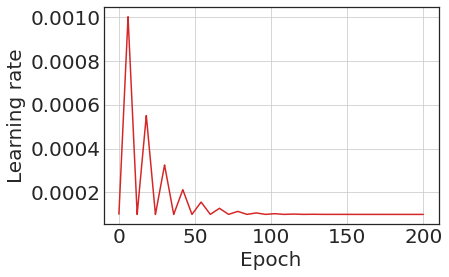

In [45]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

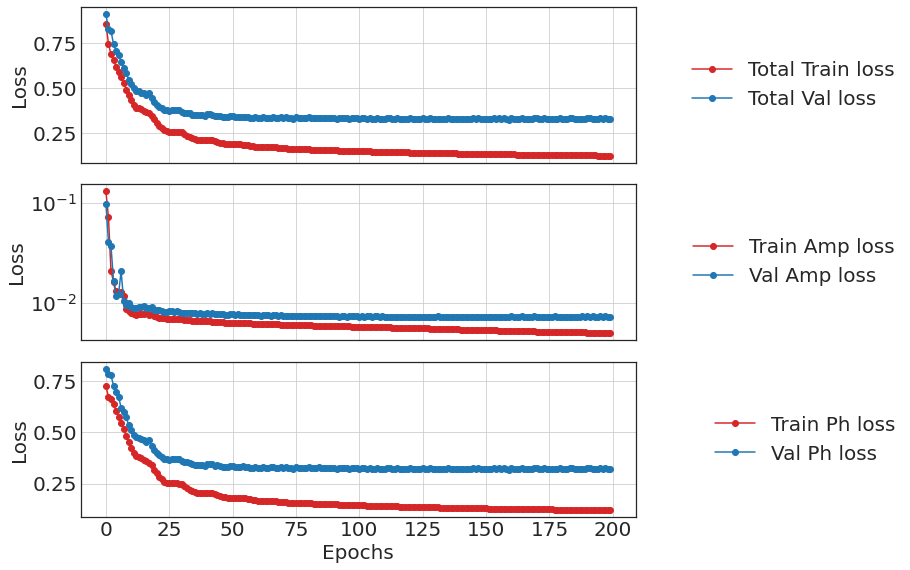

In [46]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].set_yscale('log')
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [47]:
model.eval() #imp when have dropout etc
amps_eval = []
phs_eval = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp_eval, ph_eval = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps_eval.append(amp_eval[j].detach().to("cpu").numpy())
        phs_eval.append(ph_eval[j].detach().to("cpu").numpy())

/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [48]:
amps_eval = np.array(amps_eval).squeeze()
phs_eval = np.array(phs_eval).squeeze()
print(amps_eval.shape, amps_eval.dtype)
print(phs_eval.shape, phs_eval.dtype)

(3600, 64, 64) float16
(3600, 64, 64) float16


<Figure size 432x288 with 0 Axes>

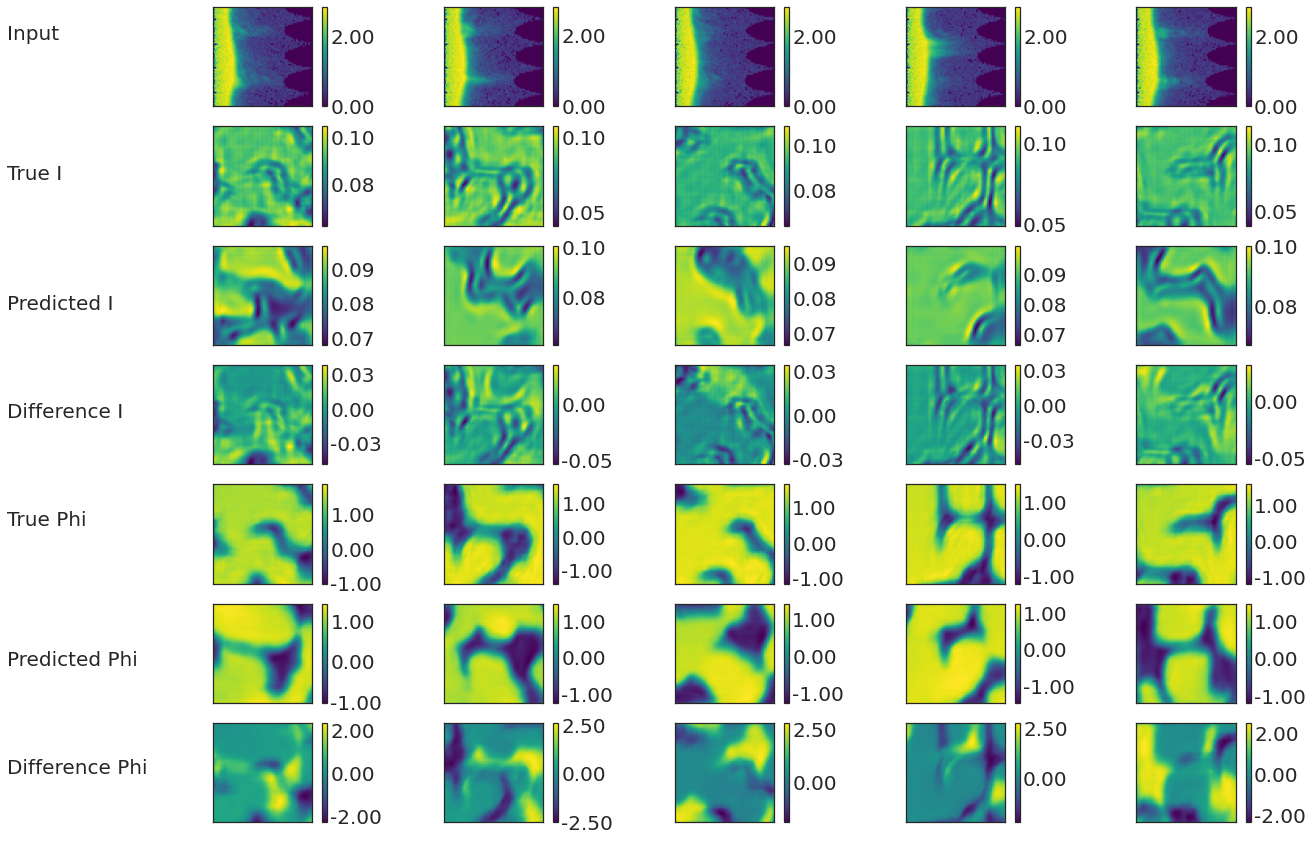

In [49]:
h,w = 64,64
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT

    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w) - amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w) - phs_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [34]:
point_size = 3
overlap = 4*point_size

In [35]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [36]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [37]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [38]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


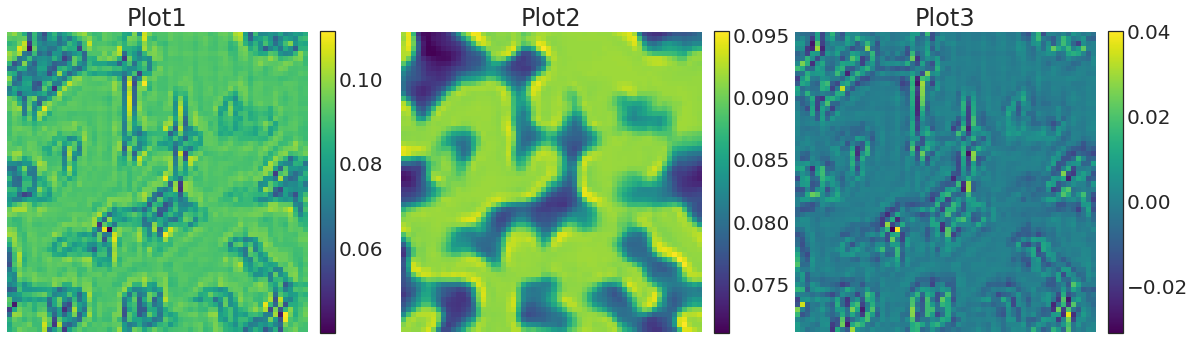

In [39]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

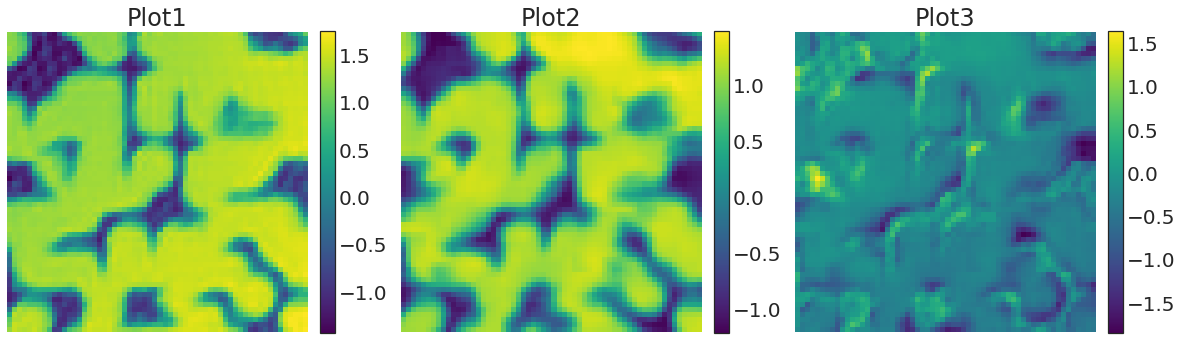

In [40]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [41]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  5.0731992093591685e-05
MSE in phase:  0.2061929170230624


In [42]:
true_img = true_amp * np.exp(1j * true_ph)
stitched_img = stitched_amp_down * np.exp(1j * stitched_phase_down)

In [43]:
_roll, _err, _phase = phase_cross_correlation(true_img[:,:,32, 32], stitched_img)
phase_cross_correlation(true_img[:,:,32,32], stitched_img * np.exp(1j * _phase))

(array([0., 0.]), 0.3566141649319918, -1.143448516556096e-16)